# 1. Carga y análisis del dataset

In [102]:
import pandas as pd

df = pd.read_csv("kindle_reviews.csv")
df.shape, df.columns

((982619, 10),
 Index(['Unnamed: 0', 'asin', 'helpful', 'overall', 'reviewText', 'reviewTime',
        'reviewerID', 'reviewerName', 'summary', 'unixReviewTime'],
       dtype='object'))

In [103]:
df.head()

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,B000F83SZQ,"[0, 0]",5,I enjoy vintage books and movies so I enjoyed reading this book. The plot was unusual. Don't think killing someone in self-defense but leaving the scene and the body without notifying the police or hitting someone in the jaw to knock them out would wash today.Still it was a good read for me.,"05 5, 2014",A1F6404F1VG29J,Avidreader,Nice vintage story,1399248000
1,1,B000F83SZQ,"[2, 2]",4,"This book is a reissue of an old one; the author was born in 1910. It's of the era of, say, Nero Wolfe. The introduction was quite interesting, explaining who the author was and why he's been forgotten; I'd never heard of him.The language is a little dated at times, like calling a gun a &#34;heater.&#34; I also made good use of my Fire's dictionary to look up words like &#34;deshabille&#34; and &#34;Canarsie.&#34; Still, it was well worth a look-see.","01 6, 2014",AN0N05A9LIJEQ,critters,Different...,1388966400
2,2,B000F83SZQ,"[2, 2]",4,"This was a fairly interesting read. It had old- style terminology.I was glad to get to read a story that doesn't have coarse, crasslanguage. I read for fun and relaxation......I like the free ebooksbecause I can check out a writer and decide if they are intriguing,innovative, and have enough of the command of Englishthat they can convey the story without crude language.","04 4, 2014",A795DMNCJILA6,dot,Oldie,1396569600
3,3,B000F83SZQ,"[1, 1]",5,I'd never read any of the Amy Brewster mysteries until this one.. So I am really hooked on them now.,"02 19, 2014",A1FV0SX13TWVXQ,"Elaine H. Turley ""Montana Songbird""",I really liked it.,1392768000
4,4,B000F83SZQ,"[0, 1]",4,"If you like period pieces - clothing, lingo, you will enjoy this mystery. Author had me guessing at least 2/3 of the way through.","03 19, 2014",A3SPTOKDG7WBLN,Father Dowling Fan,Period Mystery,1395187200


In [104]:
df.dtypes

Unnamed: 0         int64
asin              object
helpful           object
overall            int64
reviewText        object
reviewTime        object
reviewerID        object
reviewerName      object
summary           object
unixReviewTime     int64
dtype: object

Unnamed: 0        0.000000
asin              0.000000
helpful           0.000000
overall           0.000000
reviewText        0.000022
reviewTime        0.000000
reviewerID        0.000000
reviewerName      0.003890
summary           0.000121
unixReviewTime    0.000000
dtype: float64

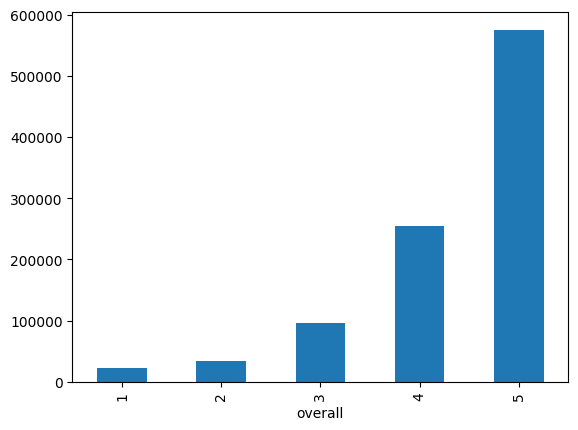

In [105]:
df["overall"].value_counts().sort_index().plot.bar()
df.isna().mean()

Las columnas que nos interesan son 'overall' (como objetivo) y 'reviewText' (como entrada). 'asin' sirve para identificar cada libro

Hay muchas que no vamos a necesitar: Unnamed: 0, reviewerName, summary, unixReviewTime

Algunas que pueden ser útiles: 'helpful', 'reviewTime' y 'reviewerID'
'Unnamed: 0', 'asin', 'helpful', 'overall', 'reviewText', 'reviewTime',
        'reviewerID', 'reviewerName', 'summary', 'unixReviewTime'


En cuanto a la distribución está muy sesgada a 5 estrellas por lo que tendremos que lidiar con este desequilibrio

In [106]:
df["reviewText_length"] = df["reviewText"].str.split().str.len()
df["reviewText_length"].describe()

count    982597.000000
mean        109.904708
std         130.813633
min           1.000000
25%          33.000000
50%          62.000000
75%         130.000000
max        4385.000000
Name: reviewText_length, dtype: float64

La longitud de media de las reseñas son 110 palabras pero tiene gran variabilidad ya que la desviación típica es 130. Por ello tendremos que filtrar las reseñas muy cortas y muy largas

# 2. Limpieza inicial de datos

Primero vamos a eliminar las variables que tienen información sin relación o utilidad en el análisis que ayaden ruido

Eliminamos: 'Unamed: 0' ya que es un índice automático; 'helpful' ya que es complejo de procesar ahora, a lo mejor lo reincorporamos luego; 'reviewerName' ya tenemos id y es texto que sobra; 'summary' no nos aporta esta información; y 'unixReviewTime' ya tenemos reviewTime.

In [107]:
df = df.drop(columns=["Unnamed: 0", "helpful", "reviewerName", "summary", "unixReviewTime"])


Ahora eliminamos las filas repetidas para eliminar el sesgo que supodría el peso extra que tendrían esas reseñas en el entrenamiento y así reducimos el tamaño sin perder información.

Suponemos que la fila está repetida si tiene exactamente el mismo texto de reseña ('reviewText') y la misma valoración ('overall')

In [108]:
size_before = len(df) #para saber cuantas filas duplicadas había
df = df.drop_duplicates(subset=["reviewText", "overall"])
size_after  = len(df)
print(f"Eliminadas {size_before-size_after} filas duplicadas")

Eliminadas 297 filas duplicadas


Otro método que podemos emplear si nuestros datos no siguen la distribución normal es el método del rango intercuartílico (IQR).

El IQR es una medida de dispersión que indica la distancia entre el primer cuartil (percentil 25) y el tercer cuartil (percentil 75) de una distribución. Puede utilizarse para identificar outliers al ayudar a definir los límites a partir de los cuales los valores se consideran atípicos. Estos límites se calculan de la siguiente manera:

Límite inferior = Q1 — (k * IQR)
Límite superior = Q3 + (k * IQR)
Donde Q1 es el primer cuartil y Q3 es el tercer cuartil. El valor más común del factor k es 1.5, aunque también se puede usar un factor de 3 o superior para identificar outliers extremos. Los valores que se encuentren por debajo del límite inferior o por encima del límite superior se consideran atípicos.

In [109]:
#longitud en palabras lo hemos calculado antes en df["reviewText_length"]
Q1, Q3 = df["reviewText_length"].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
mask = df["reviewText_length"].between(lower, upper)
df = df[mask].copy()
print(f"Filtradas {len(mask)-mask.sum()} outliers de longitud")

Filtradas 89428 outliers de longitud


Como no hay valores nulos en reviewText ni en overall y los del resto son casi nulos podemos mantenerlos sin que introduzcan sesgo

Por último ponemos la fecha como fecha y no object

In [110]:
df["reviewTime"] = pd.to_datetime(df["reviewTime"], format="%m %d, %Y", errors="coerce")
df = df.dropna(subset=["reviewTime"]) # Si alguna fecha no se ha parseado bien (NaT) la descartamos

# 3. Preprocesado texto

Vamos a procesar el texto para poder tratar los datos. 

Vamos a hacer una función que limpie el texto de la siguiente manera:
- Convertimos las contracciones a palabras por separado  
 - Poner todas las letras en minúsculas para que se trate igual la misma palabra (por ejemplo: Palabra y palabra).
 - Eliminar los caracteres no alfabéticos
 - Tokenizamos las palabras
 - Quitamos los artículos y preposiciones ya que su alta frecuencia y baja información no ayudan a discriminar

In [111]:
import re
from nltk.corpus import stopwords
#from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import contractions

stop_words = set(stopwords.words("english"))
#stemmer = SnowballStemmer("english")

def clean_text(text):
    text = contractions.fix(text)
    text = text.lower() #minusculas
    text = re.sub(r"<.*?>", " ", text) #caracteres no alfabéticos
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = word_tokenize(text) #tokenizar

    stop_words.discard('not')
    stop_words.add('book')
    stop_words.add('story')
    stop_words.add('read')
    # articulos y preposiciones y conjugaciones
    filtered = []
    for tok in tokens:
        if tok not in stop_words and len(tok) > 1:
            #stem = stemmer.stem(tok)
            filtered.append(tok)
    return " ".join(filtered)

#vocabulario único antes
todo = " ".join(df["reviewText"].str.lower())
tokens = re.findall(r"\b\w+\b", todo)
vocab_pre = set(tokens)
print("Número de palabras únicas (raw):", len(vocab_pre))

df_sample = df.sample(frac=0.1, random_state=123)
df_sample["clean_review"] = df_sample["reviewText"].apply(clean_text)

all_tokens = " ".join(df_sample["clean_review"]).split()
print("Vocab size:", len(set(all_tokens)))

#long media tokens
df_sample["tok_len"] = df_sample["clean_review"].str.split().str.len()
print(df_sample["tok_len"].describe())
df_sample.head()

Número de palabras únicas (raw): 220341
Vocab size: 67564
count    89289.000000
mean        36.436538
std         29.512807
min          0.000000
25%         15.000000
50%         26.000000
75%         48.000000
max        220.000000
Name: tok_len, dtype: float64


,asin,overall,reviewText,reviewTime,reviewerID,reviewText_length,clean_review,tok_len
307850,B009DS3L8S,3,I wasn't sure what to expect and was on the fence about reading it boy am I glad for rainy days I read it in one seating and enjoyed it.,2013-02-18,A2KJ18SSPD4ZTS,30.0,not sure expect fence reading boy glad rainy days one seating enjoyed,12
174338,B0074EC7WO,3,"This is a good story for casual reading. There are a couple motivational problems with the characters and they do go from strangers to 'in love' awfully fast. But, all in all, I read through to the end and the problems didn't distract me too much from the story.",2013-02-07,A1N4M3ZF8QFR4C,49.0,good casual reading couple motivational problems characters go strangers love awfully fast end problems not distract much,17
434003,B00BFQWO66,4,"If you are figuring out where to ""fish"" rich men. This is the guide that you should get. Not only the author provides guides, the author give advise and precautions as well.",2013-03-12,A1G2ZF3B7TOGML,32.0,figuring fish rich men guide get not author provides guides author give advise precautions well,15
198396,B007O13NBG,5,"Great book with lots of fun and nutritious smoothie recipes.. An excellent source vitamins and minerals, while being low calorie and low fat.",2013-04-14,A369IRGBXM7BQ3,23.0,great lots fun nutritious smoothie recipes excellent source vitamins minerals low calorie low fat,14
158748,B006QYJZ82,5,"I was hooked on this book after the first sentence in the prologue, 'Someone once told me that there's no such thing as a coincidence, only a synchronicity.' From that intriguing opening, we're plunged straight into the head and body of the protagonist -- who thinks quite a bit about almost everything -- and stay there, without the dizzying shifts into a dozen viewpoints in three paragraphs one sees so often in women's fiction. This is the author's third book and by the time I'd finished the second chapter (sometimes one doesn't realise quite how lucky one has been to stumble across a writer quite so in tune with one's own brain until a few moments have passed) I'd gone back to the well and purchased her previous novels to place into my personal queue of things to read. I haven't been at all sorry.This is an intelligent work of compassionate literary fiction, in my humble opinion, and not 'chick lit' by any means, although I suppose the market tends that way. It deals with divorce and love and loss, not necessarily in that order, and with a generous humanity that allows the characters to find their own way in life, make their own mistakes, recover from them, without once making anyone into a pantomime villain or cardboard heroine, as anyone who's actually gone through a divorce may sometimes be tempted to do.I highly recommend this book, for whatever that's worth.Lee-Anne",2012-08-05,A2OFCEH3O0U218,241.0,hooked first sentence prologue someone told thing coincidence synchronicity intriguing opening plunged straight head body protagonist thinks quite bit almost everything stay without dizzying shifts dozen viewpoints three paragraphs one sees often women fiction author third time would finished second chapter sometimes one not realise quite lucky one stumble across writer quite tune one brain moments passed would gone back well purchased previous novels place personal queue things not sorry intelligent work compassionate literary fiction humble opinion not chick lit means although suppose market tends way deals divorce love loss not necessarily order generous humanity allows characters find way life make mistakes recover without making anyone pantomime villain cardboard heroine anyone actually gone divorce may sometimes tempted highly recommend whatever worth lee anne,123


Hay alguna o algunas reseñas con 0 de longitud en el clean_review así que vamos a averiguar cuántas y gestionarlas

In [112]:
df_sample["length"]  = df_sample["reviewText"].str.split().str.len()

mask_empty = df_sample["tok_len"] == 0

# 2. ¿Cuántas son?
print(f"Reseñas con 0 tokens: {mask_empty.sum()} de {len(df_sample)}")

# 3. Échales un vistazo: columna original y longitud en caracteres
df_empty = df_sample.loc[mask_empty, ["reviewText", "length", "clean_review", "overall"]]
display(df_empty.head(10))

Reseñas con 0 tokens: 2 de 89289


,reviewText,length,clean_review,overall
801947,L,1,,5
887787,Read it!,2,,5


Solo son dos reviews que tras limpiar no se queda con tokens útiles. Como no aporta, lo más práctico es eliminarla y ya que sólo es 1 fila de casi 90 000, el impacto en el modelo será nulo y así evitamos ruido

In [113]:
df_sample = df_sample[df_sample["tok_len"] > 0].copy()

print("Reseñas con 0 tokens tras el drop:", (df_sample["tok_len"] == 0).sum())
print(df_sample["tok_len"].describe())

Reseñas con 0 tokens tras el drop: 0
count    89287.000000
mean        36.437354
std         29.512634
min          1.000000
25%         15.000000
50%         26.000000
75%         48.000000
max        220.000000
Name: tok_len, dtype: float64


In [114]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#tokenizar
max_words = 15000  
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_sample["clean_review"])

#convertir a secuencias
sequences = tokenizer.texts_to_sequences(df_sample["clean_review"])

#padding para igualar la longitud
max_len_75 = int(df_sample["tok_len"].quantile(0.75)) #decidimos usar el percentil 75 para eliminar ruido
print("Usaremos max_len =", max_len_75)
#max_len = 222 #longitud máxima de las secuencias (reseñas)
X = pad_sequences(sequences, maxlen=max_len_75)
y = df_sample["overall"].values-1 #variable objetivo, restamos 1 pq las clases empiezan en 1
#%pip install scikit-learn

from sklearn.model_selection import train_test_split
#dividir en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)

from collections import Counter
print("Distribución original en train:", Counter(y_train))

from sklearn.utils import class_weight
import numpy as np

# X_train_res, y_train_res ya vienen del RandomOverSampler
classes = np.unique(y_train)          # debería ser array([0,1,2,3,4])
weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)
class_weight_dict = dict(zip(classes, weights))
print("Class weights tras oversample:", class_weight_dict)


Usaremos max_len = 48
Distribución original en train: Counter({4: 26741, 3: 10965, 2: 4318, 1: 1519, 0: 1100})
Class weights tras oversample: {0: 8.116909090909092, 1: 5.877946017116524, 2: 2.067762853172765, 3: 0.8142818057455541, 4: 0.33389177667252534}


In [115]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import L2

model = Sequential([
    #capa de embedding (vectorización de palabras)
    Embedding(input_dim=max_words, output_dim=128),        #ns si hay q quitar input_length
    #capa LSTM (red neuronal recurrente con dropout para regularización)
    LSTM(128,dropout=0.2, recurrent_dropout=0.2),
    #capa densa (red neuronal totalmente conectada con regularización L2)
    Dense(64, activation="relu", kernel_regularizer=L2(0.01)),
    Dropout(0.5),
    #capa de salida (predicción de la clase con activación softmax, 5 clases para 1-5 estrellas)
    Dense(5, activation="softmax") 
])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [116]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=1,
    min_lr=1e-6
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64,
    callbacks=[early, reduce_lr],
    class_weight=class_weight_dict
)

#entrenar el modelo
#history = model.fit(X_train, y_train, batch_size=64, epochs = 5, validation_data=(X_test,y_test),verbose=1)

Epoch 1/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 109s 145ms/step - accuracy: 0.4344 - loss: 1.6624 - val_accuracy: 0.5926 - val_loss: 1.0607 - learning_rate: 0.0010
Epoch 2/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - accuracy: 0.5645 - loss: 1.1419 - val_accuracy: 0.5879 - val_loss: 1.0240 - learning_rate: 0.0010
Epoch 3/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 49s 70ms/step - accuracy: 0.6163 - loss: 0.9907 - val_accuracy: 0.6031 - val_loss: 0.9757 - learning_rate: 0.0010
Epoch 4/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 99s 142ms/step - accuracy: 0.6362 - loss: 0.9103 - val_accuracy: 0.5954 - val_loss: 0.9880 - learning_rate: 0.0010
Epoch 5/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 66s 94ms/step - accuracy: 0.6708 - loss: 0.7861 - val_accuracy: 0.5648 - val_loss: 1.0738 - learning_rate: 5.0000e-04


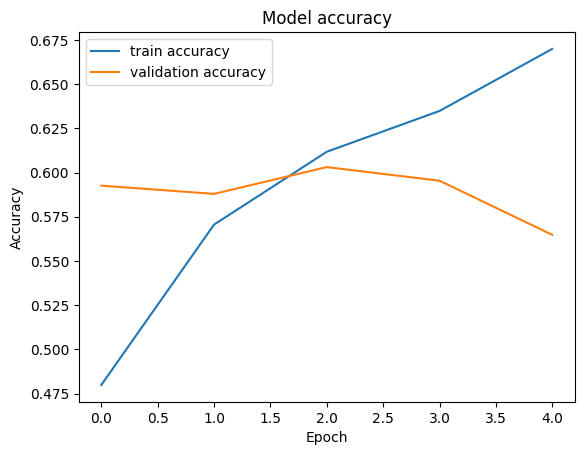

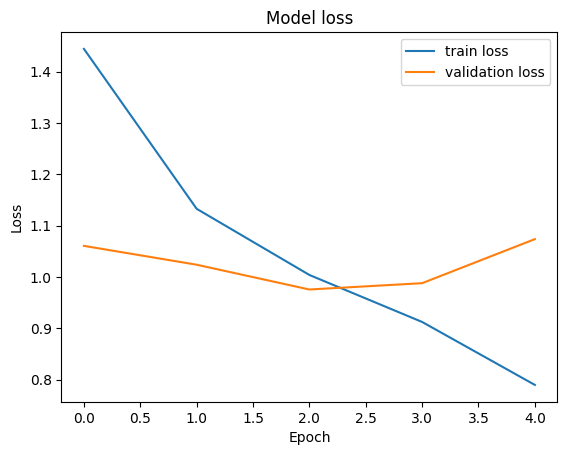

In [ ]:
#evaluacion y visualizacion
import matplotlib.pyplot as plt
#grafico d precision
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="validation accuracy")
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

#grafico d perdida
plt.plot(history.history["loss"], label = "train loss")
plt.plot(history.history["val_loss"], label = "validation loss")
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [118]:
from sklearn.feature_extraction.text import CountVectorizer

def top_ngrams_by_star(df, ngram_range=(1), top_n=30):
  for stars in sorted(df["overall"].unique()):
      texts = df.loc[df["overall"] == stars, "clean_review"]
      # Configuro el vectorizador para contar 1,2 y 3-gramas
      vec = CountVectorizer(ngram_range=(1,3),   # (min_n,max_n)
                            token_pattern=r"(?u)\b\w+\b",
                            min_df=5)            # opcional: ignora ngrams muy raros
      Xc = vec.fit_transform(texts)
      freqs = Xc.sum(axis=0).A1                # array de conteos totales por token
      idx   = freqs.argsort()[::-1][:top_n]   # índices de los top_n mayores
      feat  = vec.get_feature_names_out()

      top_items = [(feat[i], freqs[i]) for i in idx]
      line = " | ".join(f"{gram}({count})" for gram, count in top_items)

      print(f"{stars}★: {line}\n")
      

top_ngrams_by_star(df_sample, ngram_range=(1), top_n=30)


1★: not(3790) | like(779) | would(754) | one(729) | author(598) | could(594) | get(529) | time(522) | really(484) | even(448) | characters(444) | books(440) | reading(438) | good(409) | first(355) | much(320) | could not(318) | bad(291) | way(286) | short(275) | writing(262) | free(260) | sex(254) | waste(254) | written(250) | series(250) | know(250) | character(248) | love(239) | money(237)

2★: not(5372) | like(1357) | one(1192) | would(1099) | really(996) | characters(864) | good(827) | author(777) | could(771) | get(712) | much(650) | books(626) | reading(596) | short(572) | time(558) | first(546) | even(492) | way(457) | series(446) | love(409) | plot(404) | know(392) | character(378) | little(373) | sex(368) | well(367) | two(367) | end(363) | better(359) | many(358)

3★: not(11381) | would(3333) | good(3294) | like(3263) | one(2899) | characters(2437) | really(2422) | author(1920) | much(1830) | could(1775) | little(1761) | short(1747) | love(1744) | get(1732) | series(1664) | b

Vamos a ver si en base a una reseña sabe predecir las estrellas. Además vamos a ver el balanced accuracy

In [120]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import balanced_accuracy_score, f1_score

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")
# 2) Obtén las predicciones “crudas”
probs = model.predict(X_test)          # shape (n_samples, 5)
y_pred = np.argmax(probs, axis=1) + 1  # de 0–4 a 1–5

# 3) Calcula balanced accuracy y macro-F1
bal_acc  = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

print(f"Balanced accuracy: {bal_acc:.4f}")
print(f"Macro-F1         : {macro_f1:.4f}")

def predice_estrellas(review, tokenizer, model, max_len = 222):
    stop_words = set(stopwords.words("english"))

    review = contractions.fix(review)
    review = review.lower() #minusculas
    
    #limpiar texto
    #review = clean_text(review)
    review = re.sub(r"<.*?>", " ", review)          #para quitar etiquetas html y caracteres q no sean alfanumericos
    review = re.sub(r"http\S+|www\.\S+", " ", review)
    review = re.sub(r"[^a-z\s]", " ", review)
    tokens = word_tokenize(review)
    stop_words.discard('not')
    stop_words.add('book')
    stop_words.add('story')
    stop_words.add('read')
    filtered = [tok for tok in tokens if tok not in stop_words and len(tok) > 1]
    clean_review = " ".join(filtered)

    # convertir a secuencia y aplicar padding
    sequence = tokenizer.texts_to_sequences([clean_review])
    padded_sequence = pad_sequences(sequence, maxlen=max_len_75)
    # hacer la prediccion
    prediction = model.predict(padded_sequence)
    predicted_stars = np.argmax(prediction) +1 #+1 porque las clases empiezan en 0
    return predicted_stars

# Probar con una nueva reseña
new_review = "This book was awful and it disappointed me! It was super slow and i was falling sleep"
predicted_stars = predice_estrellas(new_review, tokenizer, model)
print(f"Predicción para la reseña: {predicted_stars} estrellas")


1396/1396 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.6055 - loss: 0.9705
Loss: 0.9757190346717834, Accuracy: 0.6030597686767578
1396/1396 ━━━━━━━━━━━━━━━━━━━━ 35s 25ms/step
Balanced accuracy: 0.1419
Macro-F1         : 0.1508
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


C:\Users\almug\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Predicción para la reseña: 1 estrellas


Acierta pero vemos que el balanced accuracy es muy bajo. Esto puede ser por el sesgo de las reseñas de 5 estrellas. Vamos a sacar la matriz de confusiones

1396/1396 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step
              precision    recall  f1-score   support

          1★      0.386     0.465     0.421      1065
          2★      0.213     0.381     0.273      1552
          3★      0.343     0.355     0.349      4318
          4★      0.402     0.378     0.389     10959
          5★      0.781     0.754     0.767     26750

    accuracy                          0.603     44644
   macro avg      0.425     0.466     0.440     44644
weighted avg      0.616     0.603     0.609     44644



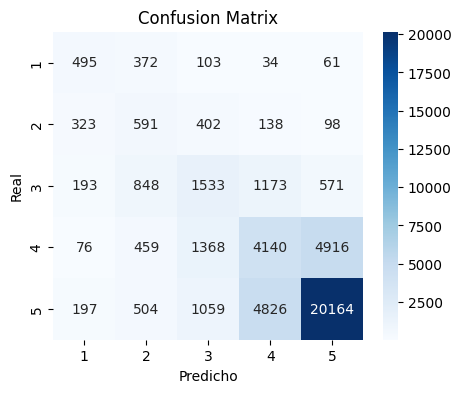

In [121]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1) Recalcula tus predicciones en 0–4
probs = model.predict(X_test)
y_pred = np.argmax(probs, axis=1)

# 2) Reporte de métricas por clase
print(classification_report(
    y_test, y_pred,
    target_names=["1★","2★","3★","4★","5★"],
    digits=3
))

# 3) Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["1","2","3","4","5"],
            yticklabels=["1","2","3","4","5"])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Confusion Matrix")
plt.show()

El modelo sabe predecir muy bien si son 5 estrellas y hemos conseguido equilibrarlo un poco al incluir los pesos. También hemos probado a hacer oversampling pero no funciona. Vamos a probar cogiendo una muestra más balanceada

In [122]:
n_per_class = df_sample["overall"].value_counts().min()
print(n_per_class)
df_balanced = (
    df_sample
    .groupby("overall", group_keys=False)
    .apply(lambda grp: grp.sample(n=n_per_class, random_state=123))
    .reset_index(drop=True)
)

#tokenizar
max_words = 15000  
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_sample["clean_review"])

#convertir a secuencias
sequences = tokenizer.texts_to_sequences(df_balanced["clean_review"])

#padding para igualar la longitud
max_len_75 = int(df_balanced["tok_len"].quantile(0.75)) #decidimos usar el percentil 75 para eliminar ruido
print("Usaremos max_len =", max_len_75)
#max_len = 222 #longitud máxima de las secuencias (reseñas)
X = pad_sequences(sequences, maxlen=max_len_75)
y = df_balanced["overall"].values-1 #variable objetivo, restamos 1 pq las clases empiezan en 1
#%pip install scikit-learn

from sklearn.model_selection import train_test_split
#dividir en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print("Distribución en train:", Counter(y_train))
from collections import Counter

from sklearn.utils import class_weight
import numpy as np

# X_train_res, y_train_res ya vienen del RandomOverSampler
classes = np.unique(y_train)          # debería ser array([0,1,2,3,4])
weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)
class_weight_dict = dict(zip(classes, weights))
print("Class weights tras oversample:", class_weight_dict)



2165


C:\Users\almug\AppData\Local\Temp\ipykernel_16492\3530120476.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.sample(n=n_per_class, random_state=123))


Usaremos max_len = 47
Distribución en train: Counter({2: 1744, 3: 1740, 4: 1731, 1: 1726, 0: 1719})
Class weights tras oversample: {0: 1.0075625363583478, 1: 1.0034762456546928, 2: 0.9931192660550459, 3: 0.9954022988505747, 4: 1.000577700751011}


In [123]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import L2

model = Sequential([
    #capa de embedding (vectorización de palabras)
    Embedding(input_dim=max_words, output_dim=128),        #ns si hay q quitar input_length
    #capa LSTM (red neuronal recurrente con dropout para regularización)
    LSTM(128,dropout=0.2, recurrent_dropout=0.2),
    #capa densa (red neuronal totalmente conectada con regularización L2)
    Dense(64, activation="relu", kernel_regularizer=L2(0.01)),
    Dropout(0.5),
    #capa de salida (predicción de la clase con activación softmax, 5 clases para 1-5 estrellas)
    Dense(5, activation="softmax") 
])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [124]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=1,
    min_lr=1e-6
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64,
    callbacks=[early, reduce_lr],
)


Epoch 1/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.2482 - loss: 2.0897 - val_accuracy: 0.3764 - val_loss: 1.3685 - learning_rate: 0.0010
Epoch 2/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.4141 - loss: 1.2703 - val_accuracy: 0.4490 - val_loss: 1.2523 - learning_rate: 0.0010
Epoch 3/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.5102 - loss: 1.0896 - val_accuracy: 0.4693 - val_loss: 1.2488 - learning_rate: 0.0010
Epoch 4/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.6207 - loss: 0.9275 - val_accuracy: 0.4850 - val_loss: 1.2594 - learning_rate: 0.0010
Epoch 5/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7063 - loss: 0.7768 - val_accuracy: 0.4711 - val_loss: 1.3636 - learning_rate: 5.0000e-04


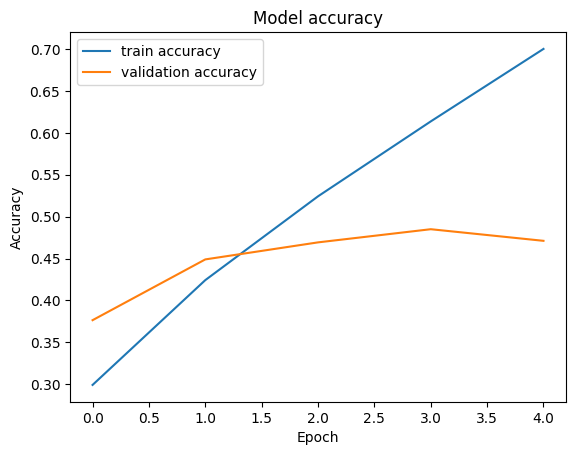

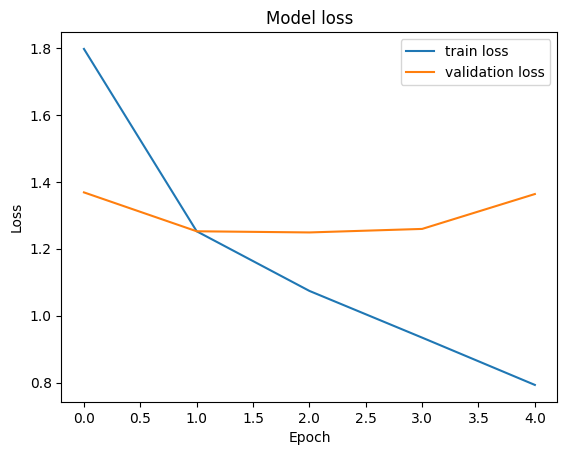

In [125]:
#evaluacion y visualizacion
import matplotlib.pyplot as plt
#grafico d precision
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="validation accuracy")
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

#grafico d perdida
plt.plot(history.history["loss"], label = "train loss")
plt.plot(history.history["val_loss"], label = "validation loss")
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [126]:
from sklearn.feature_extraction.text import CountVectorizer

def top_ngrams_by_star(df, ngram_range=(1), top_n=30):
  for stars in sorted(df["overall"].unique()):
      texts = df.loc[df["overall"] == stars, "clean_review"]
      # Configuro el vectorizador para contar 1,2 y 3-gramas
      vec = CountVectorizer(ngram_range=(1,3),   # (min_n,max_n)
                            token_pattern=r"(?u)\b\w+\b",
                            min_df=5)            # opcional: ignora ngrams muy raros
      Xc = vec.fit_transform(texts)
      freqs = Xc.sum(axis=0).A1                # array de conteos totales por token
      idx   = freqs.argsort()[::-1][:top_n]   # índices de los top_n mayores
      feat  = vec.get_feature_names_out()

      top_items = [(feat[i], freqs[i]) for i in idx]
      line = " | ".join(f"{gram}({count})" for gram, count in top_items)

      print(f"{stars}★: {line}\n")
      

top_ngrams_by_star(df_sample, ngram_range=(1), top_n=30)


1★: not(3790) | like(779) | would(754) | one(729) | author(598) | could(594) | get(529) | time(522) | really(484) | even(448) | characters(444) | books(440) | reading(438) | good(409) | first(355) | much(320) | could not(318) | bad(291) | way(286) | short(275) | writing(262) | free(260) | sex(254) | waste(254) | written(250) | series(250) | know(250) | character(248) | love(239) | money(237)

2★: not(5372) | like(1357) | one(1192) | would(1099) | really(996) | characters(864) | good(827) | author(777) | could(771) | get(712) | much(650) | books(626) | reading(596) | short(572) | time(558) | first(546) | even(492) | way(457) | series(446) | love(409) | plot(404) | know(392) | character(378) | little(373) | sex(368) | well(367) | two(367) | end(363) | better(359) | many(358)

3★: not(11381) | would(3333) | good(3294) | like(3263) | one(2899) | characters(2437) | really(2422) | author(1920) | much(1830) | could(1775) | little(1761) | short(1747) | love(1744) | get(1732) | series(1664) | b

In [127]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import balanced_accuracy_score, f1_score

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")
# 2) Obtén las predicciones “crudas”
probs = model.predict(X_test)          # shape (n_samples, 5)
y_pred = np.argmax(probs, axis=1) + 1  # de 0–4 a 1–5

# 3) Calcula balanced accuracy y macro-F1
bal_acc  = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

print(f"Balanced accuracy: {bal_acc:.4f}")
print(f"Macro-F1         : {macro_f1:.4f}")

def predice_estrellas(review, tokenizer, model, max_len = 222):
    stop_words = set(stopwords.words("english"))

    review = contractions.fix(review)
    review = review.lower() #minusculas
    
    #limpiar texto
    #review = clean_text(review)
    review = re.sub(r"<.*?>", " ", review)          #para quitar etiquetas html y caracteres q no sean alfanumericos
    review = re.sub(r"http\S+|www\.\S+", " ", review)
    review = re.sub(r"[^a-z\s]", " ", review)
    tokens = word_tokenize(review)
    stop_words.discard('not')
    stop_words.add('book')
    stop_words.add('story')
    stop_words.add('read')
    filtered = [tok for tok in tokens if tok not in stop_words and len(tok) > 1]
    clean_review = " ".join(filtered)

    # convertir a secuencia y aplicar padding
    sequence = tokenizer.texts_to_sequences([clean_review])
    padded_sequence = pad_sequences(sequence, maxlen=max_len_75)
    # hacer la prediccion
    prediction = model.predict(padded_sequence)
    predicted_stars = np.argmax(prediction) +1 #+1 porque las clases empiezan en 0
    return predicted_stars

# Probar con una nueva reseña
new_review = "This book was awful and it disappointed me! It was super slow and i was falling sleep"
predicted_stars = predice_estrellas(new_review, tokenizer, model)
print(f"Predicción para la reseña: {predicted_stars} estrellas")


68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4843 - loss: 1.2133
Loss: 1.248832106590271, Accuracy: 0.4692840576171875
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Balanced accuracy: 0.1625
Macro-F1         : 0.1374
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicción para la reseña: 1 estrellas


C:\Users\almug\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
              precision    recall  f1-score   support

          1★      0.631     0.529     0.576       446
          2★      0.398     0.371     0.384       439
          3★      0.358     0.356     0.357       421
          4★      0.387     0.435     0.410       425
          5★      0.583     0.650     0.614       434

    accuracy                          0.469      2165
   macro avg      0.471     0.468     0.468      2165
weighted avg      0.473     0.469     0.469      2165



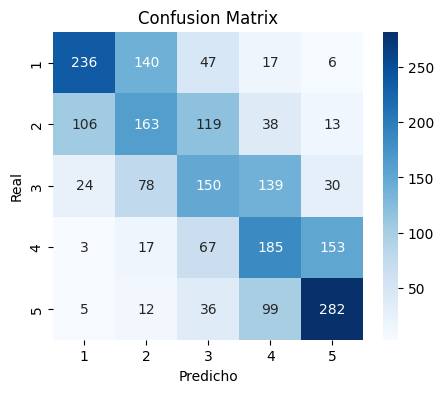

In [128]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1) Recalcula tus predicciones en 0–4
probs = model.predict(X_test)
y_pred = np.argmax(probs, axis=1)

# 2) Reporte de métricas por clase
print(classification_report(
    y_test, y_pred,
    target_names=["1★","2★","3★","4★","5★"],
    digits=3
))

# 3) Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["1","2","3","4","5"],
            yticklabels=["1","2","3","4","5"])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Confusion Matrix")
plt.show()

Ha mejorado bastante y está mucho más balanceado. Ahora vamos a intentar que reconozca palabras que van juntas ya que reconocer solo una lleva a confusión

In [129]:
df_balanced.head()

,asin,overall,reviewText,reviewTime,reviewerID,reviewText_length,clean_review,tok_len,length
0,B00I3449SE,1,"Worst mess I have seen in a while. No grammar check, SO so poorly written even for free you should get money back for this mess.",2014-06-01,A10MZXDN5JIPAW,26.0,worst mess seen grammar check poorly written even free get money back mess,13,26
1,B006T3P1TM,1,"This book was awful. First off if I ever heard my Pastor's wife talk the way Sam does in this book I would leave my church. The way Beth, and Jason talk to each is dirty, and not christ like at all. Plus there were plenty of other dirty words in this book. This author needs his mouth washed out with soap, and a good kick in the back side if he thinks God was glorified with this book. One minute quotes so called Bible verses, then the next cussing, and dirty talk between to unmarried adults. Crazy. I will not be reading anything else from this author, and would be embarresed to recommend it.",2012-10-19,A8DEIUNJYJG2H,115.0,awful first ever heard pastor wife talk way sam would leave church way beth jason talk dirty not christ like plus plenty dirty words author needs mouth washed soap good kick back side thinks god glorified one minute quotes called bible verses next cussing dirty talk unmarried adults crazy not reading anything else author would embarresed recommend,57,115
2,B007Z3QVGW,1,Sadly this historical romance was just plain boring. The writing was simply not good enough to make the story interesting.,2013-09-29,A2VZCC8Z6XOZCL,20.0,sadly historical romance plain boring writing simply not good enough make interesting,12,20
3,B0047GN6AE,1,"In recent months I have received review copies of 3 books by Duane Gundrum through Librarything.com and I will not request any more. This latest offering, Innocent Till Proven Guilty, was published in 2010 and for this promotional re-release Mr. Gundrum did not bother to check the editing. The book is unreadable. Six mistakes in the ~500 word prologue and an additional 10 in the first few pages of Chapter 1. I quit then. The other 2 were not this bad.",2014-05-11,A14FIEMIY1LMTD,81.0,recent months received review copies books duane gundrum librarything com not request latest offering innocent till proven guilty published promotional release mr gundrum not bother check editing unreadable six mistakes word prologue additional first pages chapter quit not bad,39,81
4,B0090MXP0Q,1,"This story is super short and utterly predictable. I read it in 10 minutes or less and it wasn't worth my time. The story itself is ok, but you know how the story will end up the moment you start reading.",2012-12-05,AWQ5YS116IEGN,41.0,super short utterly predictable minutes less not worth time ok know end moment start reading,15,41


Ahora vamos a intentar que reconzca ngramas antes de entrenar ya que creemos que pierde información

In [130]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import class_weight
from collections import Counter
import numpy as np

# 1) Partimos de tu df_sample y hacemos el balanceo:
n_per_class = df_sample["overall"].value_counts().min()
print("Número de muestras por clase:", n_per_class)

# 2) Función para crear bi‐ y tri‐gramas “pegados” con guión bajo
def text_with_ngrams(text):
    toks = text.split()
    bigrams  = ["_".join(toks[i:i+2]) for i in range(len(toks)-1)]
    trigrams = ["_".join(toks[i:i+3]) for i in range(len(toks)-2)]
    return " ".join(toks + bigrams + trigrams)

# 3) Generamos la nueva columna sobre la que entrenaremos
df_balanced["ngram_review"] = df_balanced["clean_review"].apply(text_with_ngrams)



Número de muestras por clase: 2165


In [131]:
from sklearn.feature_extraction.text import CountVectorizer

def top_ngrams_by_star(df, ngram_range=(1,2,3), top_n=20):
    """
    Imprime los TOP n-gramas más frecuentes para cada valor de 'overall' en df.
    
    Args:
      df            : DataFrame que tiene columnas 'overall' y 'ngram_review'
      ngram_range   : tupla con los tamaños de ngram (ej. (1,2,3))
      top_n         : cuántos n-gramas mostrar por clase
    """
    for stars in sorted(df["overall"].unique()):
        texts = df.loc[df["overall"] == stars, "ngram_review"]
        # Configuro el vectorizador para contar 1,2 y 3-gramas
        vec = CountVectorizer(ngram_range=(1,3),   # (min_n,max_n)
                              token_pattern=r"(?u)\b\w+\b",
                              min_df=5)            # opcional: ignora ngrams muy raros
        Xc = vec.fit_transform(texts)
        freqs = Xc.sum(axis=0).A1                # array de conteos totales por token
        idx   = freqs.argsort()[::-1][:top_n]   # índices de los top_n mayores
        feat  = vec.get_feature_names_out()
        
        print(f"\nTOP {top_n} n-gramas para {stars} estrella{'s' if stars>1 else ''}:")
        for i in idx:
            print(f"  {feat[i]:<25} {freqs[i]:>5d}")

top_ngrams_by_star(df_balanced, ngram_range=(1,3), top_n=20)



TOP 20 n-gramas para 1 estrella:
  not                        3790
  like                        779
  would                       754
  one                         729
  author                      598
  could                       594
  get                         529
  time                        522
  really                      484
  even                        448
  characters                  444
  books                       440
  reading                     438
  good                        409
  first                       355
  much                        320
  could not                   318
  could_not                   318
  bad                         291
  way                         286

TOP 20 n-gramas para 2 estrellas:
  not                        3808
  like                        941
  one                         847
  would                       789
  really                      701
  characters                  616
  good                        567
  could      

In [134]:
from sklearn.feature_extraction.text import CountVectorizer

def top_k_ngrams(texts, ngram, top_n=10, min_df=5):
    """Devuelve los top_n n-gramas de tamaño exacto ngram."""
    vec = CountVectorizer(ngram_range=(ngram, ngram),
                          token_pattern=r"(?u)\b\w+\b",
                          min_df=min_df)
    Xc    = vec.fit_transform(texts)
    freqs = Xc.sum(axis=0).A1
    feat  = vec.get_feature_names_out()
    idx   = freqs.argsort()[::-1][:top_n]
    return [(feat[i], freqs[i]) for i in idx]

for stars in sorted(df_balanced["overall"].unique()):
    texts = df_balanced.loc[df_balanced["overall"]==stars, "ngram_review"]
    print(f"\n=== {stars} estrella{'s' if stars>1 else ''} ===")
    print("Unigrams:",  top_k_ngrams(texts, 1, top_n=8))
    print("Bigrams: ",  top_k_ngrams(texts, 2, top_n=8))
    print("Trigrams:",  top_k_ngrams(texts, 3, top_n=8))



=== 1 estrella ===
Unigrams: [('not', 3790), ('like', 779), ('would', 754), ('one', 729), ('author', 598), ('could', 594), ('get', 529), ('time', 522)]
Bigrams:  [('could not', 318), ('not even', 195), ('waste time', 157), ('not like', 146), ('not get', 138), ('would not', 134), ('not waste', 119), ('not worth', 104)]
Trigrams: [('not waste time', 70), ('could not get', 63), ('would not recommend', 49), ('could not finish', 47), ('not waste money', 37), ('not even finish', 35), ('could not even', 35), ('not recommend anyone', 26)]

=== 2 estrellas ===
Unigrams: [('not', 3808), ('like', 941), ('one', 847), ('would', 789), ('really', 701), ('characters', 616), ('good', 567), ('could', 562)]
Bigrams:  [('could not', 242), ('not like', 142), ('not get', 125), ('would not', 117), ('not really', 109), ('not know', 91), ('not even', 81), ('felt like', 81)]
Trigrams: [('could not get', 63), ('would not recommend', 43), ('really wanted like', 21), ('not cup tea', 21), ('could not finish', 21),

In [135]:
df_balanced.head()

,asin,overall,reviewText,reviewTime,reviewerID,reviewText_length,clean_review,tok_len,length,ngram_review
0,B00I3449SE,1,"Worst mess I have seen in a while. No grammar check, SO so poorly written even for free you should get money back for this mess.",2014-06-01,A10MZXDN5JIPAW,26.0,worst mess seen grammar check poorly written even free get money back mess,13,26,worst mess seen grammar check poorly written even free get money back mess worst_mess mess_seen seen_grammar grammar_check check_poorly poorly_written written_even even_free free_get get_money money_back back_mess worst_mess_seen mess_seen_grammar seen_grammar_check grammar_check_poorly check_poorly_written poorly_written_even written_even_free even_free_get free_get_money get_money_back money_back_mess
1,B006T3P1TM,1,"This book was awful. First off if I ever heard my Pastor's wife talk the way Sam does in this book I would leave my church. The way Beth, and Jason talk to each is dirty, and not christ like at all. Plus there were plenty of other dirty words in this book. This author needs his mouth washed out with soap, and a good kick in the back side if he thinks God was glorified with this book. One minute quotes so called Bible verses, then the next cussing, and dirty talk between to unmarried adults. Crazy. I will not be reading anything else from this author, and would be embarresed to recommend it.",2012-10-19,A8DEIUNJYJG2H,115.0,awful first ever heard pastor wife talk way sam would leave church way beth jason talk dirty not christ like plus plenty dirty words author needs mouth washed soap good kick back side thinks god glorified one minute quotes called bible verses next cussing dirty talk unmarried adults crazy not reading anything else author would embarresed recommend,57,115,awful first ever heard pastor wife talk way sam would leave church way beth jason talk dirty not christ like plus plenty dirty words author needs mouth washed soap good kick back side thinks god glorified one minute quotes called bible verses next cussing dirty talk unmarried adults crazy not reading anything else author would embarresed recommend awful_first first_ever ever_heard heard_pastor pastor_wife wife_talk talk_way way_sam sam_would would_leave leave_church church_way way_beth beth_jason jason_talk talk_dirty dirty_not not_christ christ_like like_plus plus_plenty plenty_dirty dirty_words words_author author_needs needs_mouth mouth_washed washed_soap soap_good good_kick kick_back back_side side_thinks thinks_god god_glorified glorified_one one_minute minute_quotes quotes_called called_bible bible_verses verses_next next_cussing cussing_dirty dirty_talk talk_unmarried unmarried_adults adults_crazy crazy_not not_reading reading_anything anything_else else_author author_would would_embarresed embarresed_recommend awful_first_ever first_ever_heard ever_heard_pastor heard_pastor_wife pastor_wife_talk wife_talk_way talk_way_sam way_sam_would sam_would_leave would_leave_church leave_church_way church_way_beth way_beth_jason beth_jason_talk jason_talk_dirty talk_dirty_not dirty_not_christ not_christ_like christ_like_plus like_plus_plenty plus_plenty_dirty plenty_dirty_words dirty_words_author words_author_needs author_needs_mouth needs_mouth_washed mouth_washed_soap washed_soap_good soap_good_kick good_kick_back kick_back_side back_side_thinks side_thinks_god thinks_god_glorified god_glorified_one glorified_one_minute one_minute_quotes minute_quotes_called quotes_called_bible called_bible_verses bible_verses_next verses_next_cussing next_cussing_dirty cussing_dirty_talk dirty_talk_unmarried talk_unmarried_adults unmarried_adults_crazy adults_crazy_not crazy_not_reading not_reading_anything reading_anything_else anything_else_author else_author_would author_would_embarresed would_embarresed_recommend
2,B007Z3QVGW,1,Sadly this historical romance was just plain boring. The writing was simply not good enough to make the story interesting.,2013-09-29,A2VZCC8Z6XOZCL,20.0,sadly historical roman

No se están genrando bien los ngramas en ngram_review, vamos a eliminarlo y hacerlo de otra manera

In [141]:
df_balanced = df_balanced.drop(columns=["ngram_review"])

In [142]:
import re

# 1) Genera la lista de los top N n-gramas (puede ser bigramas + trigramas)
top_bi = [gram for gram, _ in top_k_ngrams(df_balanced["clean_review"], ngram=2, top_n=300)]
top_tri = [gram for gram, _ in top_k_ngrams(df_balanced["clean_review"], ngram=3, top_n=200)]
top_ngrams = top_bi + top_tri

# 2) Regex que pille cualquiera de esos n-gramas, con escape
pattern = re.compile(r"\b(" + "|".join(map(re.escape, top_ngrams)) + r")\b", flags=re.IGNORECASE)

def merge_top_ngrams(text):
    # convierte "not good" → "not_good"
    return pattern.sub(lambda m: m.group(1).lower().replace(" ", "_"), text)

# 3) Aplica al DataFrame
df_balanced["ngram_review_v2"] = df_balanced["clean_review"].map(merge_top_ngrams)
pd.set_option('display.max_colwidth', None)  # Mostrar todo el texto
df_balanced.head()

,asin,overall,reviewText,reviewTime,reviewerID,reviewText_length,clean_review,tok_len,length,ngram_review_v2
0,B00I3449SE,1,"Worst mess I have seen in a while. No grammar check, SO so poorly written even for free you should get money back for this mess.",2014-06-01,A10MZXDN5JIPAW,26.0,worst mess seen grammar check poorly written even free get money back mess,13,26,worst mess seen grammar check poorly_written even free get_money_back mess
1,B006T3P1TM,1,"This book was awful. First off if I ever heard my Pastor's wife talk the way Sam does in this book I would leave my church. The way Beth, and Jason talk to each is dirty, and not christ like at all. Plus there were plenty of other dirty words in this book. This author needs his mouth washed out with soap, and a good kick in the back side if he thinks God was glorified with this book. One minute quotes so called Bible verses, then the next cussing, and dirty talk between to unmarried adults. Crazy. I will not be reading anything else from this author, and would be embarresed to recommend it.",2012-10-19,A8DEIUNJYJG2H,115.0,awful first ever heard pastor wife talk way sam would leave church way beth jason talk dirty not christ like plus plenty dirty words author needs mouth washed soap good kick back side thinks god glorified one minute quotes called bible verses next cussing dirty talk unmarried adults crazy not reading anything else author would embarresed recommend,57,115,awful first ever heard pastor wife talk way sam would leave church way beth jason talk dirty not christ like plus plenty dirty words author needs mouth washed soap good kick back side thinks god glorified one minute quotes called bible verses next cussing dirty talk unmarried adults crazy not_reading anything_else author_would embarresed recommend
2,B007Z3QVGW,1,Sadly this historical romance was just plain boring. The writing was simply not good enough to make the story interesting.,2013-09-29,A2VZCC8Z6XOZCL,20.0,sadly historical romance plain boring writing simply not good enough make interesting,12,20,sadly historical romance plain boring writing simply not_good enough make interesting
3,B0047GN6AE,1,"In recent months I have received review copies of 3 books by Duane Gundrum through Librarything.com and I will not request any more. This latest offering, Innocent Till Proven Guilty, was published in 2010 and for this promotional re-release Mr. Gundrum did not bother to check the editing. The book is unreadable. Six mistakes in the ~500 word prologue and an additional 10 in the first few pages of Chapter 1. I quit then. The other 2 were not this bad.",2014-05-11,A14FIEMIY1LMTD,81.0,recent months received review copies books duane gundrum librarything com not request latest offering innocent till proven guilty published promotional release mr gundrum not bother check editing unreadable six mistakes word prologue additional first pages chapter quit not bad,39,81,recent months received review copies books duane gundrum librarything com not request latest offering innocent till proven guilty published promotional release mr gundrum not_bother check editing unreadable six mistakes word prologue additional first pages chapter quit not_bad
4,B0090MXP0Q,1,"This story is super short and utterly predictable. I read it in 10 minutes or less and it wasn't worth my time. The story itself is ok, but you know how the story will end up the moment you start reading.",2012-12-05,AWQ5YS116IEGN,41.0,super short utterly predictable minutes less not worth time ok know end moment start reading,15,41,super short utterly predictable minutes less not_worth time ok know end moment start reading


In [143]:
df_balanced.tail()

,asin,overall,reviewText,reviewTime,reviewerID,reviewText_length,clean_review,tok_len,length,ngram_review_v2
10820,B004YQVLKO,5,This is a short and sweet book. You can read it before breakfast. I have raised chickens in years gone by and I learned a few things in this book. We didn't have the web in the 70's and 80's . The web is now a great place to get information like what Anna has written .,2013-03-16,A1ZA9KQAWM3ZPV,57.0,short sweet breakfast raised chickens years gone learned things not web web great place get information like anna written,19,57,short_sweet breakfast raised chickens years gone learned things_not web web great place get information like anna written
10821,B00B56PFJY,5,"Each person's D.N.A combination by half father and half mother, so if parent has any disease, child has a high probability have genetic disorder. This book introduces DNA and how it affects next generation. It is very useful for parents understand their gene affect children. I highly recommended this book to eveyone, not only parents.",2013-03-12,A2EE362VYVAQAQ,55.0,person combination half father half mother parent disease child high probability genetic disorder introduces dna affects next generation useful parents understand gene affect children highly recommended eveyone not parents,29,55,person combination half father half mother parent disease child high probability genetic disorder introduces dna affects next generation useful parents understand gene affect children highly_recommended eveyone not parents
10822,B009RBJYL4,5,"This was an interesting short story and it was well written. There are rumors of ghosts on college campuses, but this one seemed to bring the ghost stories to life.",2013-02-25,A2XKX5TBB6WV00,30.0,interesting short well written rumors ghosts college campuses one seemed bring ghost stories life,14,30,interesting short well_written rumors ghosts college campuses one seemed bring ghost stories life
10823,B00C7Y0T8A,5,"This fourth installment of the Sarah Woods Mystery Series finds Sarah engrossed in an emotional case of a dying woman who suspects that her husband is trying to kill her. In the meantime the private investigator- in- training is already involved in the case of a sleazy bar owner that makes and sells sex tapes.While we may suspect that we know how the story will end the writer does a great job of keeping us guessing until the very end. I very much enjoyed this book and look forward to more escapades from Sarah and her partners, Carter and Max.",2013-04-13,AVKA6UIV4LFRL,100.0,fourth installment sarah woods mystery series finds sarah engrossed emotional case dying woman suspects husband trying kill meantime private investigator training already involved case sleazy bar owner makes sells sex tapes may suspect know end writer great job keeping us guessing end much enjoyed look forward escapades sarah partners carter max,51,100,fourth installment sarah woods mystery series finds sarah engrossed emotional case dying woman suspects husband trying kill meantime private investigator training already involved case sleazy bar owner makes sells sex tapes may suspect know end writer great_job keeping us guessing end much enjoyed look_forward escapades sarah partners carter max
10824,B00KAFX90I,5,Great book! Love Dean Koontz. Read this book. Want to read more of his books. I just couldn't put it down.,2014-07-02,A805ZJAK37TEM,21.0,great love dean koontz want books could not put,9,21,great love dean koontz want books_could_not put


Vemos que se mantienen los ngramas, ahora vamos a meterlos en el modelo

In [144]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tok = Tokenizer(num_words=15000, oov_token="<UNK>")
tok.fit_on_texts(df_balanced["ngram_review_v2"])
seqs = tok.texts_to_sequences(df_balanced["ngram_review_v2"])
df_balanced["tok_len_v2"] = [len(s) for s in seqs]

max_len = int(df_balanced["tok_len_v2"].quantile(0.75))
print("Nuevo max_len:", max_len)
X = pad_sequences(seqs, maxlen=max_len, padding="post")
y = df_balanced["overall"].values - 1    # clases 0–4

# 5) División train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123, stratify=y
)
print("Distribución en train:", Counter(y_train))

# 7) Entrena tu LSTM pasando class_weight al fit()
from tensorflow.keras.models     import Sequential
from tensorflow.keras.layers     import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import L2

max_words = min(15000, len(tok.word_index) + 1)

model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation="relu", kernel_regularizer=L2(0.01)),
    Dropout(0.5),
    Dense(5, activation="softmax")
])
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=1,
    min_lr=1e-6
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64,
    callbacks=[early, reduce_lr],
    verbose=1
)

Nuevo max_len: 47
Distribución en train: Counter({0: 1732, 4: 1732, 1: 1732, 3: 1732, 2: 1732})
Epoch 1/10


C:\Users\almug\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.2067 - loss: 2.1375 - val_accuracy: 0.3557 - val_loss: 1.4670 - learning_rate: 0.0010
Epoch 2/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.3530 - loss: 1.4683 - val_accuracy: 0.3640 - val_loss: 1.3853 - learning_rate: 0.0010
Epoch 3/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.3616 - loss: 1.3503 - val_accuracy: 0.3695 - val_loss: 1.3655 - learning_rate: 0.0010
Epoch 4/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.3907 - loss: 1.2748 - val_accuracy: 0.3640 - val_loss: 1.4088 - learning_rate: 0.0010
Epoch 5/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.4057 - loss: 1.2205 - val_accuracy: 0.3848 - val_loss: 1.3609 - learning_rate: 5.0000e-04
Epoch 6/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.4124 - loss: 1.1640 - val_accuracy: 0.4129 - val_loss: 1.3009 - learning_rate: 5.0000e-04
Epoch 7/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.4526 - loss: 1.118

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
              precision    recall  f1-score   support

          1★      0.491     0.730     0.587       433
          2★      0.340     0.291     0.313       433
          3★      0.307     0.150     0.202       433
          4★      0.297     0.192     0.233       433
          5★      0.461     0.702     0.557       433

    accuracy                          0.413      2165
   macro avg      0.379     0.413     0.378      2165
weighted avg      0.379     0.413     0.378      2165



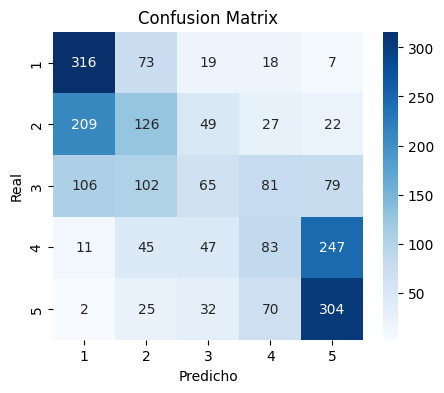

In [145]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1) Recalcula tus predicciones en 0–4
probs = model.predict(X_test)
y_pred = np.argmax(probs, axis=1)

# 2) Reporte de métricas por clase
print(classification_report(
    y_test, y_pred,
    target_names=["1★","2★","3★","4★","5★"],
    digits=3
))

# 3) Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["1","2","3","4","5"],
            yticklabels=["1","2","3","4","5"])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Confusion Matrix")
plt.show()

Con el redimiendo rondando el 35%-40% puede que el modelo se esté quedando corto, vamos a intentar hacer algún cambio a ver si mejor. Vamos a poner un bidirectioal LSTM y añadir bloques Conv1D + MaxPoooling1D para que detecte patrones locales de palabras de distinta granularidad y aligere la carga del LSTM

In [146]:
import re

max_words=20000

# 1) Genera la lista de los top N n-gramas (puede ser bigramas + trigramas)
top_bi = [gram for gram, _ in top_k_ngrams(df_balanced["clean_review"], ngram=2, top_n=200)]
top_tri = [gram for gram, _ in top_k_ngrams(df_balanced["clean_review"], ngram=3, top_n=100)]
top_ngrams = top_bi + top_tri

# 2) Regex que pille cualquiera de esos n-gramas, con escape
pattern = re.compile(r"\b(" + "|".join(map(re.escape, top_ngrams)) + r")\b", flags=re.IGNORECASE)

def merge_top_ngrams(text):
    # convierte "not good" → "not_good"
    return pattern.sub(lambda m: m.group(1).lower().replace(" ", "_"), text)

# 3) Aplica al DataFrame
df_balanced["ngram_review_v2"] = df_balanced["clean_review"].map(merge_top_ngrams)

# 4) Ahora sí fits/pad con Keras Tokenizer sobre 'ngram_review'
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

my_filter = '!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n'
tok = Tokenizer(num_words=max_words, oov_token="<UNK>",filters=my_filter, split=" ")
tok.fit_on_texts(df_balanced["ngram_review_v2"])

in_vocab = sum(
    1 for ng in top_ngrams
    if tok.word_index.get(ng.replace(" ", "_"), max_words) < max_words
)
print(f"{in_vocab}/{len(top_ngrams)} n-gramas top están dentro de los {max_words} tokens")

seqs = tok.texts_to_sequences(df_balanced["ngram_review_v2"])
df_balanced["tok_len_v2"] = [len(s) for s in seqs]

max_len = int(df_balanced["tok_len_v2"].quantile(0.75))
print("Nuevo max_len:", max_len)
X = pad_sequences(seqs, maxlen=max_len, padding="post")
y = df_balanced["overall"].values - 1    # clases 0–4

# 5) División train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123, stratify=y
)
print("Distribución en train:", Counter(y_train))

# 7) Entrena tu LSTM pasando class_weight al fit()
from tensorflow.keras.models     import Sequential
from tensorflow.keras.layers     import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.regularizers import L2

in_vocab = sum(
    1 for ng in top_ngrams
    if tok.word_index.get(ng.replace(" ", "_"), max_words) < max_words
)
print(f"{in_vocab}/{len(top_ngrams)} n-gramas top ahora están en tu vocabulario")

model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Conv1D(64, 3, activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling1D(2),
    Conv1D(128, 3, activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling1D(2),
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
    Dense(128, activation="relu", kernel_regularizer=L2(0.01)),
    Dropout(0.5),
    Dense(5, activation="softmax")
])
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=1,
    min_lr=1e-6
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64,
    callbacks=[early, reduce_lr],
    verbose=1
)

226/300 n-gramas top están dentro de los 20000 tokens
Nuevo max_len: 45
Distribución en train: Counter({0: 1732, 4: 1732, 1: 1732, 3: 1732, 2: 1732})
226/300 n-gramas top ahora están en tu vocabulario
Epoch 1/10


C:\Users\almug\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


136/136 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.2555 - loss: 2.7313 - val_accuracy: 0.2952 - val_loss: 1.8525 - learning_rate: 0.0010
Epoch 2/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5051 - loss: 1.2893 - val_accuracy: 0.3048 - val_loss: 1.6248 - learning_rate: 0.0010
Epoch 3/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7240 - loss: 0.7814 - val_accuracy: 0.4443 - val_loss: 1.3878 - learning_rate: 0.0010
Epoch 4/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8450 - loss: 0.4811 - val_accuracy: 0.4661 - val_loss: 1.3117 - learning_rate: 0.0010
Epoch 5/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9267 - loss: 0.2817 - val_accuracy: 0.4596 - val_loss: 1.9721 - learning_rate: 0.0010
Epoch 6/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9722 - loss: 0.1519 - val_accuracy: 0.4596 - val_loss: 2.2510 - learning_rate: 5.0000e-04


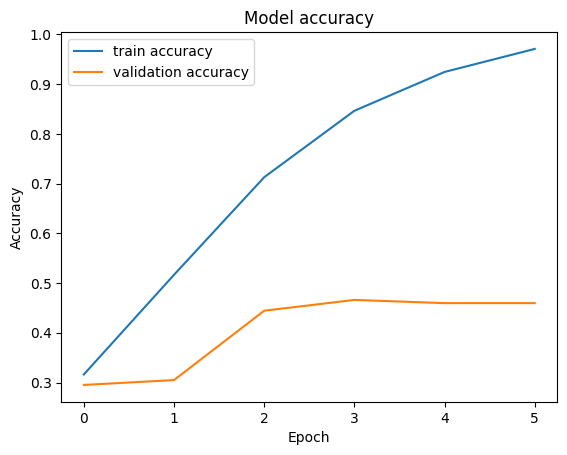

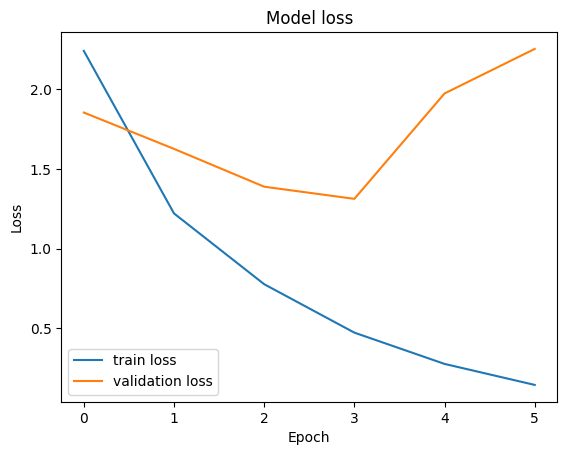

In [147]:
#evaluacion y visualizacion
import matplotlib.pyplot as plt
#grafico d precision
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="validation accuracy")
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

#grafico d perdida
plt.plot(history.history["loss"], label = "train loss")
plt.plot(history.history["val_loss"], label = "validation loss")
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

Vemos que el accuracy sale de 0.97 pero el accuracy de validación se ha estancado en 0.44, eso significa que hemos sobreajustado y la red está memorizando el train set. Por ello vamos a corregirlo quitando uno de los bloques conv/pooling y añadiendo capas de regularización (dropout)

In [148]:
import re

max_words=20000

# 1) Genera la lista de los top N n-gramas (puede ser bigramas + trigramas)
top_bi = [gram for gram, _ in top_k_ngrams(df_balanced["clean_review"], ngram=2, top_n=200)]
top_tri = [gram for gram, _ in top_k_ngrams(df_balanced["clean_review"], ngram=3, top_n=100)]
top_ngrams = top_bi + top_tri

# 2) Regex que pille cualquiera de esos n-gramas, con escape
pattern = re.compile(r"\b(" + "|".join(map(re.escape, top_ngrams)) + r")\b", flags=re.IGNORECASE)

def merge_top_ngrams(text):
    # convierte "not good" → "not_good"
    return pattern.sub(lambda m: m.group(1).lower().replace(" ", "_"), text)

# 3) Aplica al DataFrame
df_balanced["ngram_review_v2"] = df_balanced["clean_review"].map(merge_top_ngrams)

# 4) Ahora sí fits/pad con Keras Tokenizer sobre 'ngram_review'
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

my_filter = '!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n'
tok = Tokenizer(num_words=max_words, oov_token="<UNK>",filters=my_filter, split=" ")
tok.fit_on_texts(df_balanced["ngram_review_v2"])

in_vocab = sum(
    1 for ng in top_ngrams
    if tok.word_index.get(ng.replace(" ", "_"), max_words) < max_words
)
print(f"{in_vocab}/{len(top_ngrams)} n-gramas top están dentro de los {max_words} tokens")

seqs = tok.texts_to_sequences(df_balanced["ngram_review_v2"])
df_balanced["tok_len_v2"] = [len(s) for s in seqs]

max_len = int(df_balanced["tok_len_v2"].quantile(0.75))
print("Nuevo max_len:", max_len)
X = pad_sequences(seqs, maxlen=max_len, padding="post")
y = df_balanced["overall"].values - 1    # clases 0–4

# 5) División train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123, stratify=y
)
print("Distribución en train:", Counter(y_train))

# 7) Entrena tu LSTM pasando class_weight al fit()
from tensorflow.keras.models     import Sequential
from tensorflow.keras.layers     import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D, BatchNormalization, SpatialDropout1D
from tensorflow.keras.regularizers import L2

in_vocab = sum(
    1 for ng in top_ngrams
    if tok.word_index.get(ng.replace(" ", "_"), max_words) < max_words
)
print(f"{in_vocab}/{len(top_ngrams)} n-gramas top ahora están en tu vocabulario")

model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    SpatialDropout1D(0.3),

    Conv1D(64, 3, activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),
    
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    Dense(64, activation="relu", kernel_regularizer=L2(0.01)),
    Dropout(0.5),
    Dense(5, activation="softmax")
])
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=1,
    min_lr=1e-6
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64,
    callbacks=[early, reduce_lr],
    verbose=1
)

226/300 n-gramas top están dentro de los 20000 tokens
Nuevo max_len: 45
Distribución en train: Counter({0: 1732, 4: 1732, 1: 1732, 3: 1732, 2: 1732})
226/300 n-gramas top ahora están en tu vocabulario
Epoch 1/10


C:\Users\almug\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


136/136 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.2252 - loss: 2.2513 - val_accuracy: 0.3727 - val_loss: 1.7089 - learning_rate: 0.0010
Epoch 2/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.4087 - loss: 1.4446 - val_accuracy: 0.4370 - val_loss: 1.3528 - learning_rate: 0.0010
Epoch 3/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.5190 - loss: 1.1040 - val_accuracy: 0.5030 - val_loss: 1.1571 - learning_rate: 0.0010
Epoch 4/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.6506 - loss: 0.8714 - val_accuracy: 0.4878 - val_loss: 1.2052 - learning_rate: 0.0010
Epoch 5/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.7509 - loss: 0.6932 - val_accuracy: 0.4965 - val_loss: 1.3342 - learning_rate: 5.0000e-04


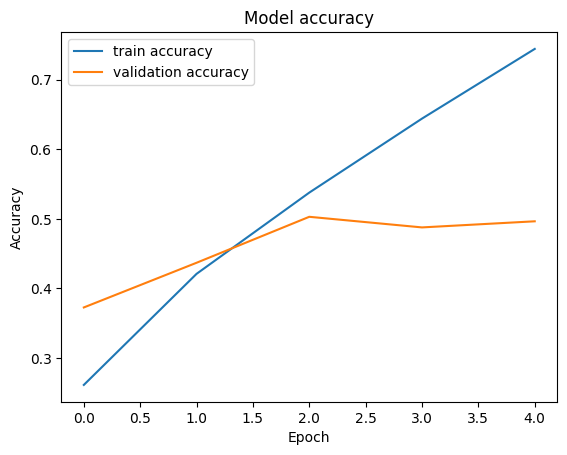

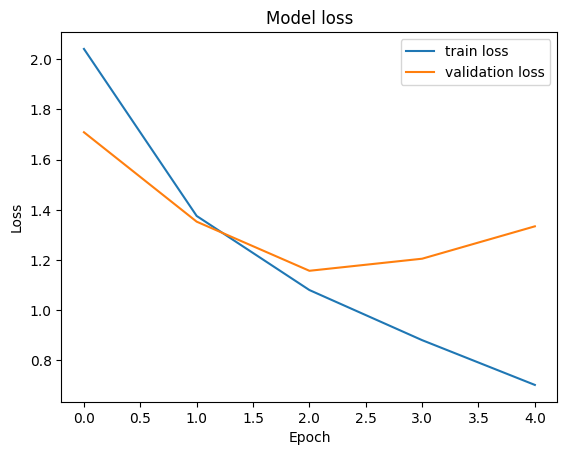

In [149]:
#evaluacion y visualizacion
import matplotlib.pyplot as plt
#grafico d precision
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="validation accuracy")
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

#grafico d perdida
plt.plot(history.history["loss"], label = "train loss")
plt.plot(history.history["val_loss"], label = "validation loss")
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [150]:
from sklearn.feature_extraction.text import CountVectorizer

def top_ngrams_by_star(df, ngram_range=(1), top_n=30):
  for stars in sorted(df["overall"].unique()):
      texts = df.loc[df["overall"] == stars, "clean_review"]
      # Configuro el vectorizador para contar 1,2 y 3-gramas
      vec = CountVectorizer(ngram_range=(1,3),   # (min_n,max_n)
                            token_pattern=r"(?u)\b\w+\b",
                            min_df=5)            # opcional: ignora ngrams muy raros
      Xc = vec.fit_transform(texts)
      freqs = Xc.sum(axis=0).A1                # array de conteos totales por token
      idx   = freqs.argsort()[::-1][:top_n]   # índices de los top_n mayores
      feat  = vec.get_feature_names_out()

      top_items = [(feat[i], freqs[i]) for i in idx]
      line = " | ".join(f"{gram}({count})" for gram, count in top_items)

      print(f"{stars}★: {line}\n")
      

top_ngrams_by_star(df_sample, ngram_range=(1), top_n=30)


1★: not(3790) | like(779) | would(754) | one(729) | author(598) | could(594) | get(529) | time(522) | really(484) | even(448) | characters(444) | books(440) | reading(438) | good(409) | first(355) | much(320) | could not(318) | bad(291) | way(286) | short(275) | writing(262) | free(260) | sex(254) | waste(254) | written(250) | series(250) | know(250) | character(248) | love(239) | money(237)

2★: not(5372) | like(1357) | one(1192) | would(1099) | really(996) | characters(864) | good(827) | author(777) | could(771) | get(712) | much(650) | books(626) | reading(596) | short(572) | time(558) | first(546) | even(492) | way(457) | series(446) | love(409) | plot(404) | know(392) | character(378) | little(373) | sex(368) | well(367) | two(367) | end(363) | better(359) | many(358)

3★: not(11381) | would(3333) | good(3294) | like(3263) | one(2899) | characters(2437) | really(2422) | author(1920) | much(1830) | could(1775) | little(1761) | short(1747) | love(1744) | get(1732) | series(1664) | b

68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
              precision    recall  f1-score   support

          1★      0.636     0.573     0.603       433
          2★      0.410     0.379     0.394       433
          3★      0.407     0.640     0.497       433
          4★      0.466     0.238     0.315       433
          5★      0.628     0.686     0.656       433

    accuracy                          0.503      2165
   macro avg      0.509     0.503     0.493      2165
weighted avg      0.509     0.503     0.493      2165



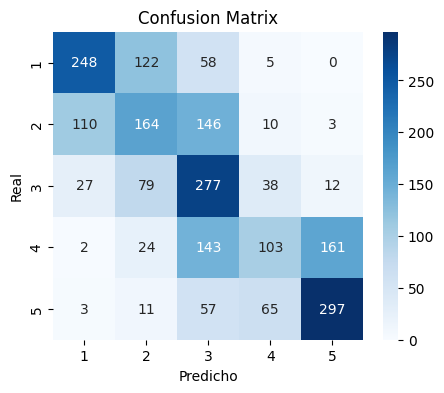

In [151]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1) Recalcula tus predicciones en 0–4
probs = model.predict(X_test)
y_pred = np.argmax(probs, axis=1)

# 2) Reporte de métricas por clase
print(classification_report(
    y_test, y_pred,
    target_names=["1★","2★","3★","4★","5★"],
    digits=3
))

# 3) Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["1","2","3","4","5"],
            yticklabels=["1","2","3","4","5"])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Confusion Matrix")
plt.show()

In [153]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import balanced_accuracy_score, f1_score

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")
# 2) Obtén las predicciones “crudas”
probs = model.predict(X_test)          # shape (n_samples, 5)
y_pred = np.argmax(probs, axis=1) + 1  # de 0–4 a 1–5

# 3) Calcula balanced accuracy y macro-F1
bal_acc  = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

print(f"Balanced accuracy: {bal_acc:.4f}")
print(f"Macro-F1         : {macro_f1:.4f}")

def predice_estrellas(review, tokenizer, model, max_len = max_len):
    stop_words = set(stopwords.words("english"))

    review = contractions.fix(review)
    review = review.lower() #minusculas
    
    #limpiar texto
    #review = clean_text(review)
    review = re.sub(r"<.*?>", " ", review)          #para quitar etiquetas html y caracteres q no sean alfanumericos
    review = re.sub(r"http\S+|www\.\S+", " ", review)
    review = re.sub(r"[^a-z\s]", " ", review)
    tokens = word_tokenize(review)
    stop_words.discard('not')
    stop_words.add('book')
    stop_words.add('story')
    stop_words.add('read')
    filtered = [tok for tok in tokens if tok not in stop_words and len(tok) > 1]
    clean_review = " ".join(filtered)

    # convertir a secuencia y aplicar padding
    sequence = tokenizer.texts_to_sequences([clean_review])
    padded_sequence = pad_sequences(sequence, maxlen=max_len_75)
    # hacer la prediccion
    prediction = model.predict(padded_sequence)
    predicted_stars = np.argmax(prediction) +1 #+1 porque las clases empiezan en 0
    return predicted_stars

# Probar con una nueva reseña
new_review = "This book was awful and it disappointed me! It was super slow and i was falling sleep"
predicted_stars = predice_estrellas(new_review, tok, model)
print(f"Predicción para la reseña: {predicted_stars} estrellas")


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5089 - loss: 1.1685
Loss: 1.1570937633514404, Accuracy: 0.5030022859573364
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Balanced accuracy: 0.1834
Macro-F1         : 0.1521
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicción para la reseña: 2 estrellas


C:\Users\almug\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
